# Table of contents


In [400]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import KNNImputer

#Contexto

**Swetro** es una aplicación en la que los usuarios se registran para competir en retos deportivos de running, ciclismo y caminata, ya sea para ganar premios o simplemente por el espíritu de competencia. Para participar, los usuarios registran sus actividades mediante relojes inteligentes de marcas como Garmin, Suunto, Wahoo, IgpSport, Polar y Apple Watch, o a través de las apps móviles oficiales de estas marcas desde un dispositivo móvil.

Uno de los desafíos recurrentes que enfrenta Swetro es la detección de actividades sospechosas o incoherentes, las cuales pueden surgir por diversas razones, tales como:

*   Errores en los sensores de los dispositivos, lo que genera registros  
incorrectos en métricas cómo la velocidad, distancia o ritmo cardíaco.

*  Registros humanamente imposibles, como velocidades extremas o distancias cubiertas en tiempos irrealistas.

*  Uso inadecuado del dispositivo, por ejemplo, dejarlo encendido todo el día sin realizar actividad física real.

*  Intento de fraude, donde un usuario registra una actividad pero en realidad realizó otra (ejemplo: marcar una caminata como un trote).

*  Aprovechamiento de medios externos, como subirse a un vehículo o utilizar una bicicleta eléctrica para obtener mejores tiempos y distancias.

Por lo tanto, para evitar que estas irregularidades afecten la competencia justa y la validez de los premios, es necesario desarrollar un sistema de detección de actividades atípicas o sospechosas.

Para este estudio, se utilizará un dataset de los últimos 5 meses (octubre 2024 - febrero 2025) con registros de actividades deportivas:

*  Cada fila representa una actividad registrada por un usuario.
*  Cada columna corresponde a una variable o característica de la actividad, como distancia, tiempo, velocidad promedio, ritmo cardíaco promedio, elevación ganada, etc.

Dado que las irregularidades pueden variar según la disciplina deportiva, este análisis se centrará exclusivamente en los registros de running, buscando patrones que indiquen posibles fraudes o datos erróneos.

#Descripción de los campos

Las variables que describen cada actividad son los siguientes:

*  **UserId:** Identificador único del usuario en la base de datos de la empresa.
*  **Type:** Tipo de actividad registrada (*Running, Cycling, Walking, Other*).
*  **Name:** Nombre asignado a la actividad, ya sea por el usuario o automáticamente por la aplicación.
*  **StartTimeUtc:** Fecha y hora de inicio de la actividad en UTC (*Tiempo Universal Coordinado*).
*  **DurationInSeconds:** Duración total de la actividad medida en segundos.
*  **DistanceInMeters:** Distancia recorrida durante la actividad, expresada en metros.
*  **Steps:** Número total de pasos registrados durante la actividad.
*  **AverageSpeedInMetersPerSecond:** Velocidad promedio alcanzada durante la actividad, expresada en metros por segundo.
*  **AveragePaceInMinutesPerKilometer:** Ritmo promedio de la actividad, expresado en minutos por kilómetro.
*  **TotalElevationGainInMeters:** Suma total de la elevación ganada en la actividad, expresada en metros.
*  **TotalElevationLossInMeters:** Suma total de la elevación perdida en la actividad, expresada en metros.
*  **AverageHeartRateInBeatsPerMinute:** Frecuencia cardíaca promedio durante la actividad, medida en latidos por minuto (*BPM*).
*  **SourceType:** Marca del dispositivo con el cual se registró la actividad (*Garmin, Suunto, Wahoo, IgpSports, Polar, Apple Watch*).
*  **SourceName:** Modelo del dispositivo o aplicación que registró la actividad (ejemplo: *Garmin Forerunner 945, fēnix 3 HR, etc*).
*  **Warnings:** Indicadores de posibles anomalías detectadas en la actividad. Se generan alertas en los siguientes casos:
  1.  Si la duración de la actividad es menor a 5 minutos.
  2.  Si es una actividad de ciclismo y la elevación ganada supera los 16 metros por minuto (1,000 metros por hora).
  3.  Si es una actividad de running y la elevación ganada supera los 8 metros por minuto (500 metros por hora).
  4.  Si es una actividad de running con un ritmo promedio menor a 3.5 minutos por kilómetro (3:30 min/km).
  5.  Si la actividad no registra distancia recorrida.

*  **CreationTime:** Fecha y hora en la que el registro de la actividad fue creado en la base de datos.

#Análisis exploratorio

Empezaremos por revisar la estructura del dataset, la consistencia entre los datos y que tengan el formato adecuado.



##Análisis de estructura

In [402]:
df = pd.read_excel('./DatasetActivitiesRunning.xlsx', engine="openpyxl")
df_original = df.copy()
df.shape

(351195, 16)

Los datos cuentan con 351.195 observaciones y 16 columnas

In [346]:
df.head()

,UserId,Type,Name,StartTimeUtc,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute,SourceType,SourceName,Warnings,CreationTime
0,56226720,Running,Avellaneda Carrera,2024-09-30 20:36:15.0000000 +00:00,2308,6050.10,6802.0,2.622,6.356471,127.971985,128.66255,145.0,Garmin,Forerunner 35,NaN,2024-10-01 00:00:32.7421846 +00:00
1,33958672,Running,Malvinas Argentinas Carrera,2024-09-30 23:43:23.0000000 +00:00,232,557.72,600.0,2.399,6.947340,NaN,1.00000,91.0,Garmin,Forerunner 255S Music,DurationLessThanFiveMinutes,2024-10-01 00:00:37.8144259 +00:00
2,33958672,Running,Malvinas Argentinas Carrera,2024-09-30 23:53:23.0000000 +00:00,320,770.48,856.0,2.407,6.924248,3.000000,1.00000,114.0,Garmin,Forerunner 255S Music,NaN,2024-10-01 00:00:52.2962825 +00:00
3,39156304,Running,Córdoba Carrera,2024-09-30 23:26:07.0000000 +00:00,1895,5005.62,5254.0,2.642,6.308352,96.905790,107.28553,146.0,Garmin,Forerunner 45,NaN,2024-10-01 00:01:02.0718947 +00:00
4,10154408,Running,Rosario Carrera,2024-09-30 21:59:39.0000000 +00:00,4386,10376.22,11452.0,2.365,7.047216,71.099960,71.93257,143.0,Garmin,Forerunner 55,NaN,2024-10-01 00:01:30.1037912 +00:00


In [347]:
df.isna().sum()

UserId                                   0
Type                                     0
Name                                     0
StartTimeUtc                             0
DurationInSeconds                        0
DistanceInMeters                       979
Steps                                 4008
AverageSpeedInMetersPerSecond          994
AveragePaceInMinutesPerKilometer      1052
TotalElevationGainInMeters           33316
TotalElevationLossInMeters           32925
AverageHeartRateInBeatsPerMinute     13214
SourceType                               0
SourceName                             999
Warnings                            316327
CreationTime                             0
dtype: int64

Se puede ver que hay datos vacíos, para las variables DistanceInMeters, Steps, AverageSpeedInMetersPerSeconds, AveragePaceInMinutesPerKilometer, TotalElevationGainInMeters,TotalElevationLossInMeters, AverageHeartRateInBeatsPerMinute, SourceName y Warnings. En el proceso de limpieza se decidirá qué hacer con estas observaciones.

In [348]:
list(df.columns)

['UserId',
 'Type',
 'Name',
 'StartTimeUtc',
 'DurationInSeconds',
 'DistanceInMeters',
 'Steps',
 'AverageSpeedInMetersPerSecond',
 'AveragePaceInMinutesPerKilometer',
 'TotalElevationGainInMeters',
 'TotalElevationLossInMeters',
 'AverageHeartRateInBeatsPerMinute',
 'SourceType',
 'SourceName',
 'Warnings',
 'CreationTime']

##Análisis de variables categóricas

Según la descripción de los campos, las siguientes variables son categoricas: SourceType, SourceName

In [349]:
df.dtypes

UserId                                int64
Type                                 object
Name                                 object
StartTimeUtc                         object
DurationInSeconds                     int64
DistanceInMeters                    float64
Steps                               float64
AverageSpeedInMetersPerSecond       float64
AveragePaceInMinutesPerKilometer    float64
TotalElevationGainInMeters          float64
TotalElevationLossInMeters          float64
AverageHeartRateInBeatsPerMinute    float64
SourceType                           object
SourceName                           object
Warnings                             object
CreationTime                         object
dtype: object

In [350]:
df.describe()

,UserId,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,TotalElevationGainInMeters,TotalElevationLossInMeters,AverageHeartRateInBeatsPerMinute
count,3.511950e+05,3.511950e+05,3.502160e+05,347187.000000,350201.000000,350143.000000,317879.000000,318270.000000,337981.000000
mean,4.654385e+07,2.902295e+03,7.597329e+03,7281.422167,2.775515,10.367149,130.991368,130.137395,140.610724
std,2.720984e+07,4.155384e+03,6.691007e+03,6108.132035,2.214866,420.801629,1961.576560,1972.627785,25.404904
min,2.024000e+03,-1.764163e+06,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.501057e+07,1.325000e+03,3.283648e+03,2808.000000,2.357000,5.289326,11.150000,11.000000,132.000000
50%,4.397545e+07,2.581000e+03,6.708120e+03,6568.000000,2.751000,6.057513,32.200000,32.510000,144.000000
75%,7.083190e+07,3.763000e+03,1.009291e+04,10074.000000,3.149000,7.071135,82.000000,83.829982,155.000000
max,9.799196e+07,8.019640e+05,1.148765e+06,220378.000000,997.690002,209166.666667,784072.300000,783765.800000,239.000000


In [351]:
(df.value_counts('SourceType', normalize=True) * 100).round(2).astype(str) + '%'

SourceType
Garmin    91.68%
Coros       3.2%
Polar      2.74%
Wahoo      1.22%
Suunto     1.13%
Apple      0.03%
Name: proportion, dtype: object

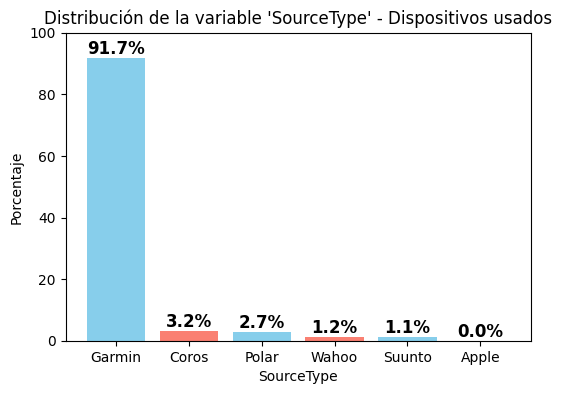

In [352]:
porcentajes = (df.value_counts('SourceType', normalize=True) * 100).round(2)

plt.figure(figsize=(6, 4))
bars = plt.bar(porcentajes.index, porcentajes, color=['skyblue', 'salmon'])

# Agregar las etiquetas
for bar, porcentaje in zip(bars, porcentajes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("SourceType")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'SourceType' - Dispositivos usados")
plt.ylim(0, 100)
plt.show()

Un análisis en base a las fuentes de información no es viable debido a que el dataset en este sentido está desbalanceado

In [353]:
(df.value_counts('SourceName', normalize=True) * 100).round(2).astype(str) + '%'

SourceName
Forerunner 55           7.65%
Forerunner 235           5.5%
Forerunner 245 Music    4.75%
Forerunner 965          4.42%
Forerunner 45           4.06%
                        ...  
Amazfit GTS 4 Mini       0.0%
Instinct Crossover       0.0%
Suunto Race S            0.0%
Wahoo ELEMNT RIVAL       0.0%
fenix 6S Solar           0.0%
Name: proportion, Length: 240, dtype: object

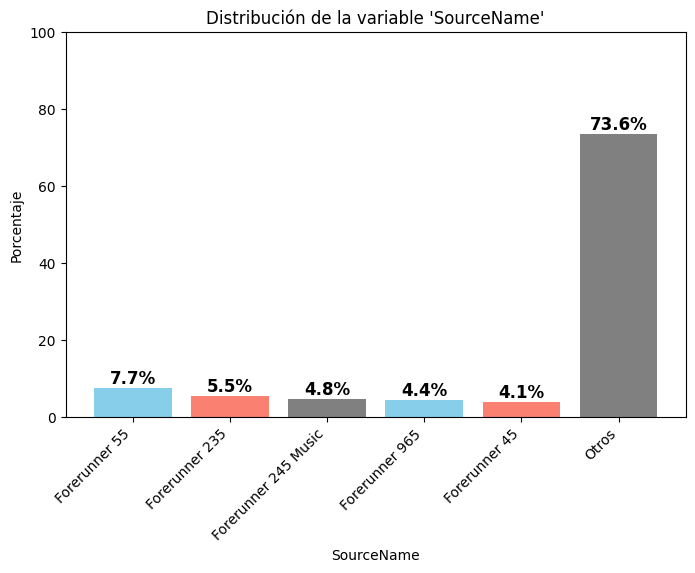

In [354]:
porcentajes = (df.value_counts('SourceName', normalize=True) * 100).round(2)

umbral = 4
categorias_importantes = porcentajes[porcentajes >= umbral]
otros = porcentajes[porcentajes < umbral].sum()
if otros > 0:
    categorias_importantes["Otros"] = otros

plt.figure(figsize=(8, 5))
bars = plt.bar(categorias_importantes.index, categorias_importantes, color=['skyblue', 'salmon', 'gray'])

for bar, porcentaje in zip(bars, categorias_importantes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{porcentaje:.1f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("SourceName")
plt.ylabel("Porcentaje")
plt.title("Distribución de la variable 'SourceName'")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.show()

Tratamiento de variables que inicialmente se determina no son relevantes para lograr el objetivo.
Se mantendrá una copia de df para mantener la información original y poder hacer comparaciones - df_original

In [403]:
# Eliminar Warnings porque puede presentarse data leakage
df = df.drop('Warnings', axis=1)

# Eliminar UserId porque el ID de un usuario no representa infromación relevante para el análisis
df = df.drop('UserId', axis=1)

# Eliminar Name representa el nombre de la actividad, pero no es relevante para el análisis
df = df.drop('Name', axis=1)

# Eliminar Type debido a que solo vamos a tomar los registros de Running por lo que solo habría una categoria en Type
df = df.drop('Type', axis=1)

# Para el startTimeUtc decidimos dividir el valor en día, fecha, año y hora
df['StartTimeUtc'] = pd.to_datetime(df['StartTimeUtc'])

df['Year'] = df['StartTimeUtc'].dt.year
df['Month'] = df['StartTimeUtc'].dt.month
df['Day'] = df['StartTimeUtc'].dt.day
df['Hour'] = df['StartTimeUtc'].dt.hour

# Además agregamos una variable adicional que represente el día de la semana en el cual realizó el ejercicio (Donde 0 es lunes, 1 es martes, etc)
df['Day_of_week'] = df['StartTimeUtc'].dt.dayofweek

# Eliminar startTimeUtc
df = df.drop('StartTimeUtc', axis=1)

# Eliminar la variable CreationTime debido a que no es de valor para el análisis porque representa la fecha en la cual se registró la actividad en la base de datos
df = df.drop('CreationTime', axis=1)

# Eliminar la variable SourceType debido a que el 91.7% datos corresponden al mismo valor
df = df.drop('SourceType', axis=1)

# TODO: ¿Eliminar sourceName?


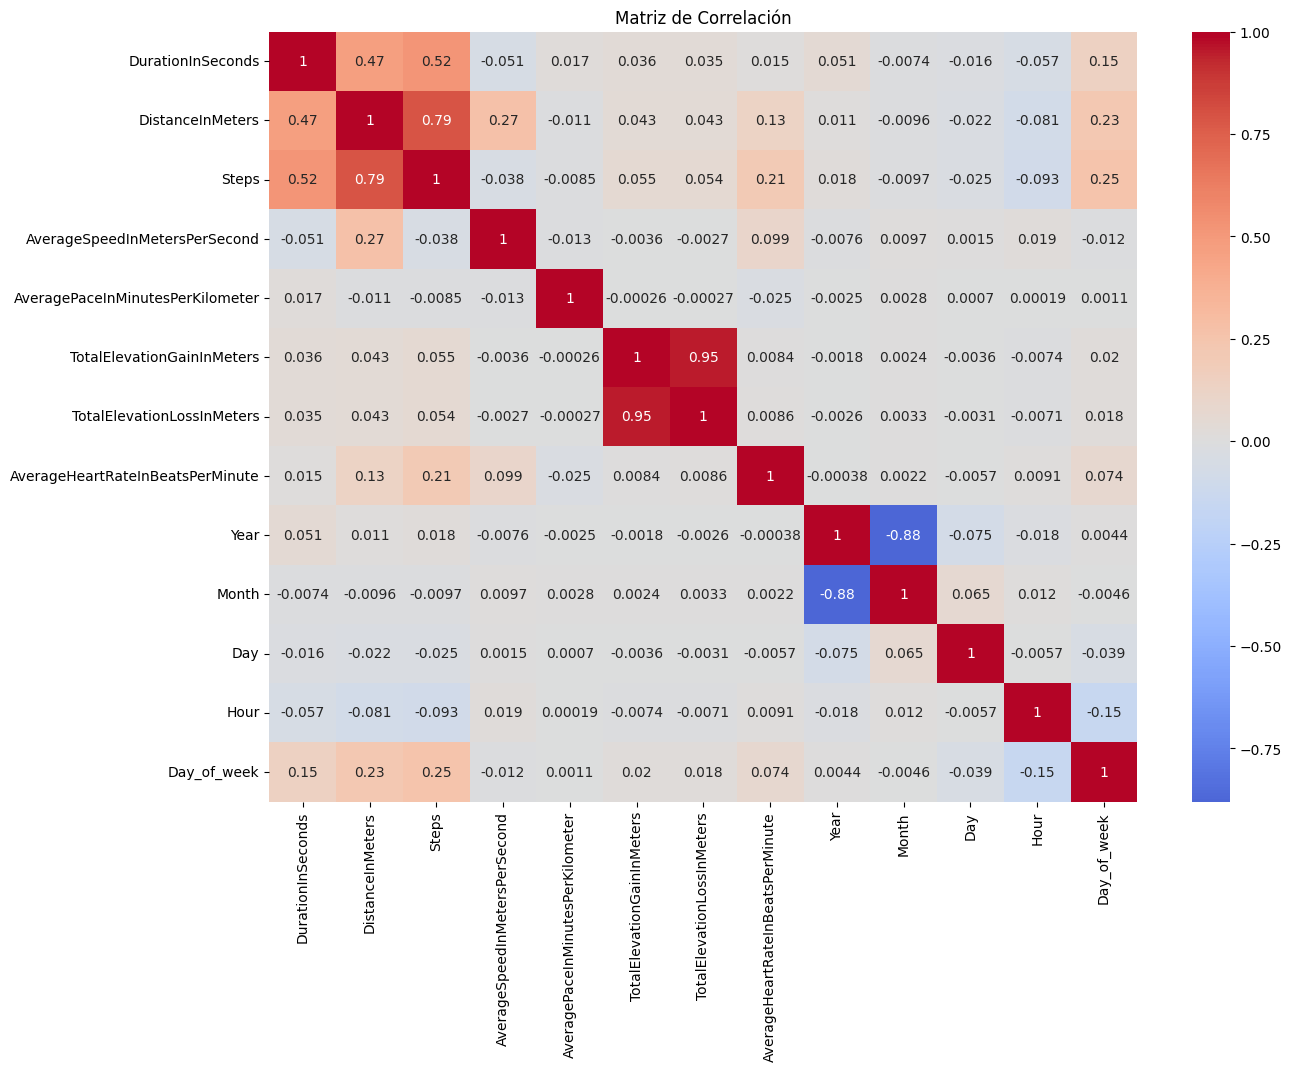

In [356]:
# Crear matriz de correlación

df_numericas = df.select_dtypes(include=['number'])
corr_matrix = df_numericas.corr()

# Heatmap de la matriz de correlacion
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()


In [357]:
integer_columns = df.select_dtypes(include=['int64']).columns
print("Variables enteras en el dataset:", integer_columns)


Variables enteras en el dataset: Index(['DurationInSeconds'], dtype='object')


##Análisis de variables continuas


# Análisis de DurationInSeconds

Tiempos nulos o negativos no tienen sentido práctico en nuestro análisis, así que se eliminarán del dataset

In [358]:
len(df[(df['DurationInSeconds']<=0)])

207

In [404]:
# Eliminar registros con duración menos o igual a 0
df = df[(df["DurationInSeconds"] > 0)]

In [360]:
len(df[(df['DurationInSeconds']>100000)])

2

Para facilitar el análisis inicial se eliminarán los 2 registros que superan los 100000 segundos que representan más de 27 continuas.

In [405]:
# Eliminar registros con duración menos o igual a 0
df = df[(df["DurationInSeconds"] < 100000)]

In [362]:
df['DurationInSeconds'].describe()

count    350986.000000
mean       2906.486578
std        2552.759128
min           1.000000
25%        1328.000000
50%        2582.000000
75%        3764.000000
max       95739.000000
Name: DurationInSeconds, dtype: float64

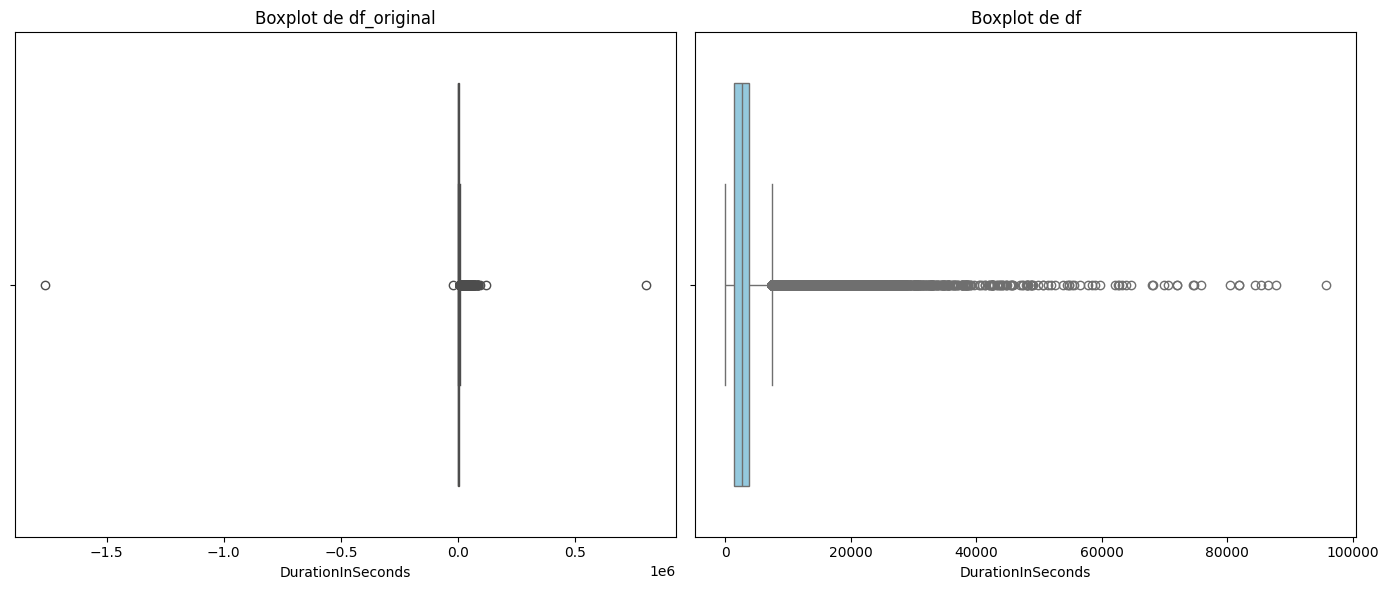

In [363]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

sns.boxplot(data=df_original, x='DurationInSeconds', color='orange', ax=axes[0])
axes[0].set_title('Boxplot de df_original')

sns.boxplot(data=df, x='DurationInSeconds', color='skyblue', ax=axes[1])
axes[1].set_title('Boxplot de df')

plt.tight_layout() 
plt.show()

# Análisis de DistanceInMeters

Esta variable tiene 508 registros menores o iguales a 0. Considerando que estamos analizando una actividad deportiva de tipo Running, registros sin distancia válida no serán útiles para el análisis

In [364]:
len(df[(df['DistanceInMeters']<=0)])

508

In [406]:
# Eliminar registros con distancia menor o igual a 0
df = df[(df["DistanceInMeters"] > 0)]

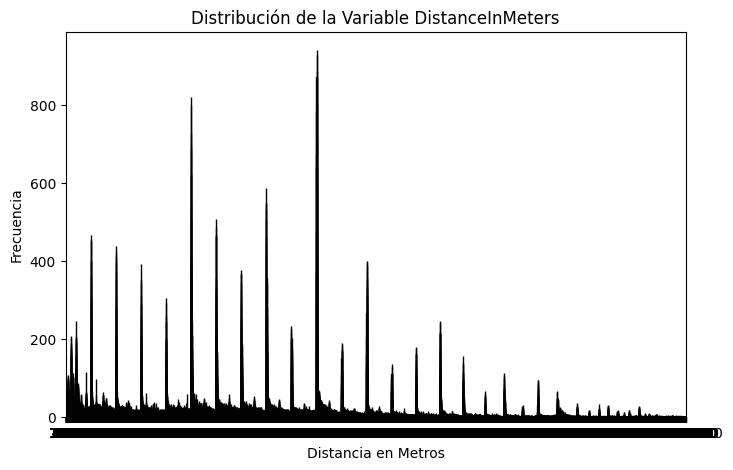

In [ ]:
# Contenteo de datos solo con números enteros para la variable DistanceInMeters. Esto solo con fines analíticos, no se afectará el dataset original
acumuladorDistancias = df['DistanceInMeters'].round().value_counts().sort_index()

plt.figure(figsize=(8, 5))
acumuladorDistancias.plot(kind='bar', color='skyblue', edgecolor='black')

# Personalizar etiquetas
plt.xlabel('Distancia en Metros')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Variable DistanceInMeters')
plt.xticks(rotation=0)

plt.show()

# Análisis de AverageSpeedInMetersPerSecond

La velocidad máxima registrada de un ser humano corriendo es de aproximadamente 12.42 metros por segundo (m/s). Los datos confirman que la mayor cantidad de datos se encuentran por debajo de este número.
Se eliminan los 34 registros por encima de 19 m/s

In [366]:
len(df[(df['AverageSpeedInMetersPerSecond'] >= 19)])

34

In [407]:
df = df[(df["AverageSpeedInMetersPerSecond"] < 19)]
df['AverageSpeedInMetersPerSecond'].describe()

count    349552.000000
mean          2.770834
std           0.817439
min           0.000000
25%           2.360000
50%           2.752000
75%           3.150000
max          18.912000
Name: AverageSpeedInMetersPerSecond, dtype: float64

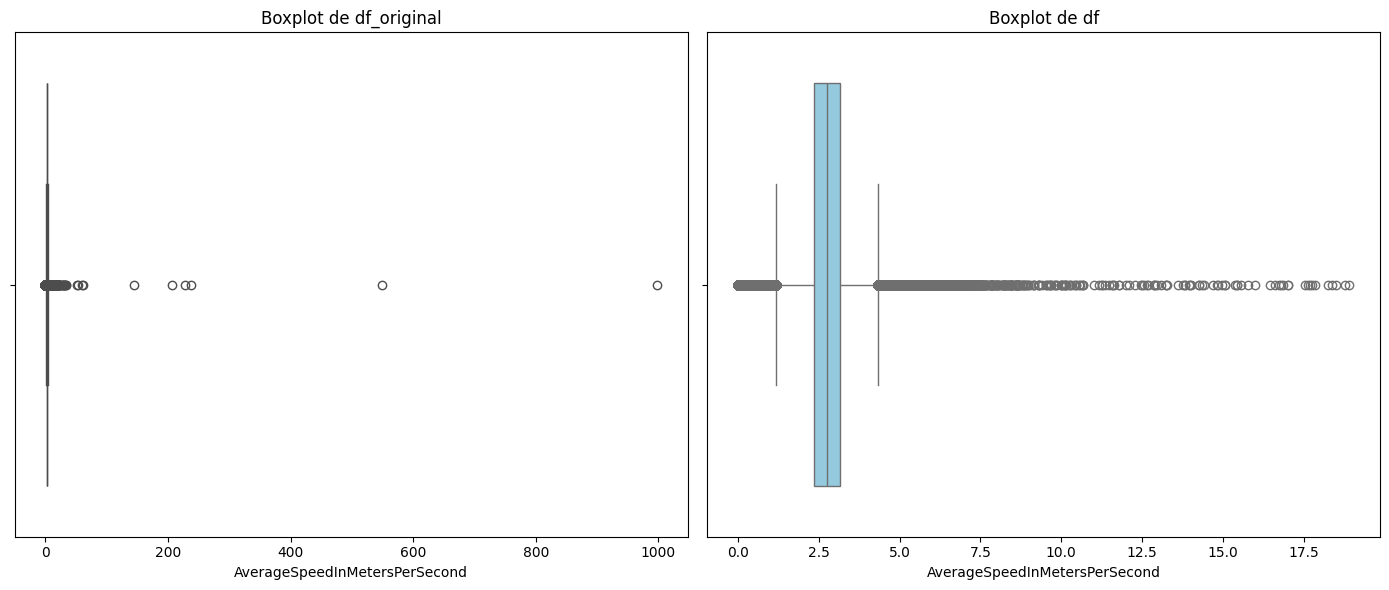

In [368]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

sns.boxplot(data=df_original, x='AverageSpeedInMetersPerSecond', color='orange', ax=axes[0])
axes[0].set_title('Boxplot de df_original')

sns.boxplot(data=df, x='AverageSpeedInMetersPerSecond', color='skyblue', ax=axes[1])
axes[1].set_title('Boxplot de df')

plt.tight_layout() 
plt.show()

# Análisis de TotalElevationGainInMeters y TotalElevationLossInMeters

Eliminar los 2 outliers que entorpecen el entendimiento de las variables TotalElevationGainInMeters y TotalElevationLossInMeters

In [369]:
print(len(df[(df["TotalElevationGainInMeters"] > 100000)]), len(df[(df["TotalElevationLossInMeters"] > 100000)]))

2 2


In [408]:
df = df[(df["TotalElevationGainInMeters"] < 100000)]
df = df[(df["TotalElevationLossInMeters"] < 100000)]

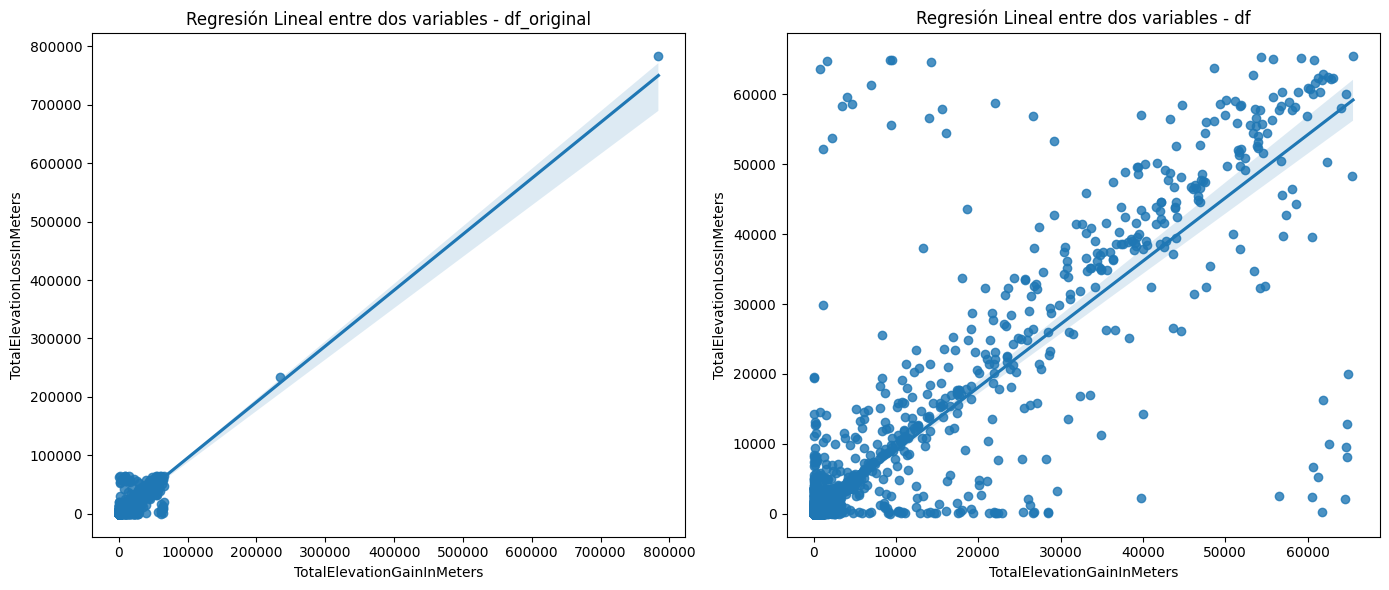

In [371]:
# Se analizará TotalElevationGainInMeters y TotalElevationLossInMeters debido a que presentan una correlación muy alta

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.regplot(x=df_original["TotalElevationGainInMeters"], y=df_original["TotalElevationLossInMeters"], ax=axes[0])
axes[0].set_title('Regresión Lineal entre dos variables - df_original')

sns.regplot(x=df["TotalElevationGainInMeters"], y=df["TotalElevationLossInMeters"], ax=axes[1])
axes[1].set_title('Regresión Lineal entre dos variables - df')
plt.tight_layout() 
plt.show()

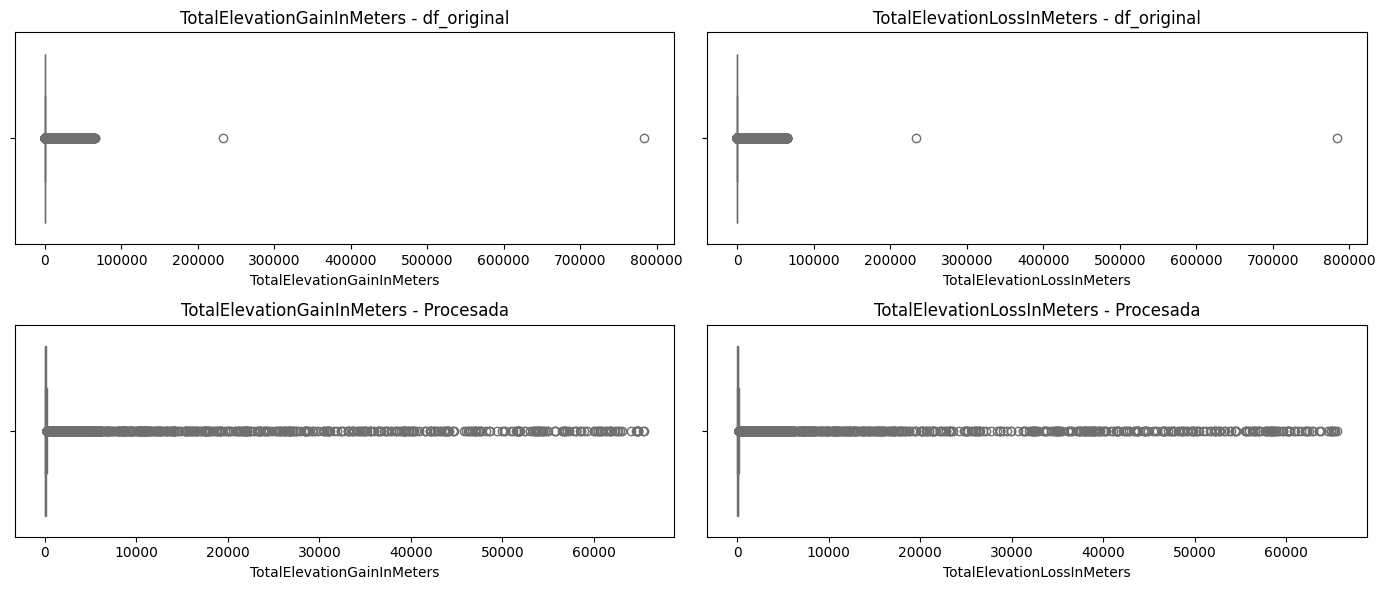

In [372]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
sns.boxplot(data=df_original, x='TotalElevationGainInMeters', color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('TotalElevationGainInMeters - df_original')

sns.boxplot(data=df_original, x='TotalElevationLossInMeters', color='skyblue', ax=axes[0, 1])
axes[0, 1].set_title('TotalElevationLossInMeters - df_original')

sns.boxplot(data=df, x='TotalElevationGainInMeters', color='skyblue', ax=axes[1, 0])
axes[1, 0].set_title('TotalElevationGainInMeters - Procesada')

sns.boxplot(data=df, x='TotalElevationLossInMeters', color='skyblue', ax=axes[1, 1])
axes[1, 1].set_title('TotalElevationLossInMeters - Procesada')

plt.tight_layout() 
plt.show()

In [373]:
df['TotalElevationGainInMeters'].describe()

count    306017.000000
mean        130.746344
std        1336.812092
min           0.000000
25%          12.893066
50%          34.000000
75%          85.000000
max       65513.100000
Name: TotalElevationGainInMeters, dtype: float64

Debido a que las variables manejadas individualmente tiene un alto porcentaje de nulos:
TotalElevationGainInMeters: 33316 registros nulos
TotalElevationLossInMeters: 32925 registros nulos
Y se consideran importantes para el sistema de detección, se hace una transformación clasificando el terreno recorrido por el usuario como: 
- **Flat**: Si TotalElevationGainInMeters y TotalElevationLossInMeters son 0 o nulos
- **Uphill**: Si TotalElevationGainInMeters es mayor a 0 y TotalElevationLossInMeters es 0
- **Downhill**: Si TotalElevationGainInMeters es 0 y TotalElevationLossInMeters es mayor a 0
- **Mixed**: Si TotalElevationGainInMeters y TotalElevationLossInMeters son mayores a 0

In [409]:
# Debido a que se observa un alta correlación entre ambas variables lo que nos indica que si se usan como predictoras para el modelo podemos tener problemas de colinealidad
"""
Se considera que la variable TotalElevationGainInMeters y TotalElevationLossInMeters aportan información relevante para el análisis, 
por tanto se computará una columna adicional que represente el tipo de terreno en el cual se realizó la actividad
    1. Flat: Si TotalElevationGainInMeters y TotalElevationLossInMeters son 0 o nulos
    2. Uphill: Si TotalElevationGainInMeters es mayor a 0 y TotalElevationLossInMeters es 0
    3. Downhill: Si TotalElevationGainInMeters es 0 y TotalElevationLossInMeters es mayor a 0
    4. Mixed: Si TotalElevationGainInMeters y TotalElevationLossInMeters son mayores a 0
"""
df['TerrainType'] = 'Flat'  # Initialize with 'Flat'
df.loc[(df['TotalElevationGainInMeters'] > 0) & (df['TotalElevationLossInMeters'] == 0), 'TerrainType'] = 'Uphill'
df.loc[(df['TotalElevationGainInMeters'] == 0) & (df['TotalElevationLossInMeters'] > 0), 'TerrainType'] = 'Downhill'
df.loc[(df['TotalElevationGainInMeters'] > 0) & (df['TotalElevationLossInMeters'] > 0), 'TerrainType'] = 'Mixed'


# Eliminar las variables usadas para crear TerrainType
df = df.drop('TotalElevationGainInMeters', axis=1)
df = df.drop('TotalElevationLossInMeters', axis=1)

In [375]:
df.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,SourceName,Year,Month,Day,Hour,Day_of_week,TerrainType
0,2308,6050.10,6802.0,2.622,6.356471,145.0,Forerunner 35,2024,9,30,20,0,Mixed
2,320,770.48,856.0,2.407,6.924248,114.0,Forerunner 255S Music,2024,9,30,23,0,Mixed
3,1895,5005.62,5254.0,2.642,6.308352,146.0,Forerunner 45,2024,9,30,23,0,Mixed
4,4386,10376.22,11452.0,2.365,7.047216,143.0,Forerunner 55,2024,9,30,21,0,Mixed
5,3054,8013.14,8424.0,2.624,6.351625,152.0,Forerunner 55,2024,9,30,23,0,Mixed


DistanceInMeters                                               \
                       count         mean          std   min          25%   
TerrainType                                                                 
Downhill              2437.0  4430.399695  3717.051023  2.00  1320.660000   
Flat                  7283.0  6727.385732  7296.857779  0.01  2246.280029   
Mixed               294203.0  8439.311098  5999.026367  2.61  4872.980000   
Uphill                2094.0  5605.947732  5177.965245  3.00  1623.725000   

                                            DurationInSeconds               \
                 50%         75%        max             count         mean   
TerrainType                                                                  
Downhill     3466.65   6509.4900   25013.00            2437.0  1677.442347   
Flat         5792.50  10007.8400  337600.00            7283.0  2891.392421   
Mixed        7509.94  10597.7550  539273.00          294203.0  3222.888832   
Uphill       4917.13   8140.1025   67343.49            2094.0  2169.064470   

             ... AverageSpeedInMetersPerSecond          \
             ...                           75%     max   
TerrainType  ...                                         
Downhill     ...                         3.177   8.173   
Flat         ...                         3.038  10.570   
Mixed        ...                         3.106  18.775   
Uphill       ...                         3.063  14.273   

            AverageHeartRateInBeatsPerMinute                              \
                                       count        mean        std  min   
TerrainType                                                                
Downhill                              2429.0  138.095513  25.156379  0.0   
Flat                                  7222.0   71.936721  71.830019  0.0   
Mixed                               285244.0  143.373273  19.620137  0.0   
Uphill                                2074.0  134.185632  38.320830  0.0   

                                         
               25%    50%    75%    max  
TerrainType                              
Downhill     127.0  141.0  153.0  186.0  
Flat           0.0   90.0  143.0  198.0  
Mixed        134.0  145.0  156.0  232.0  
Uphill       127.0  144.0  155.0  198.0  

[4 rows x 32 columns]

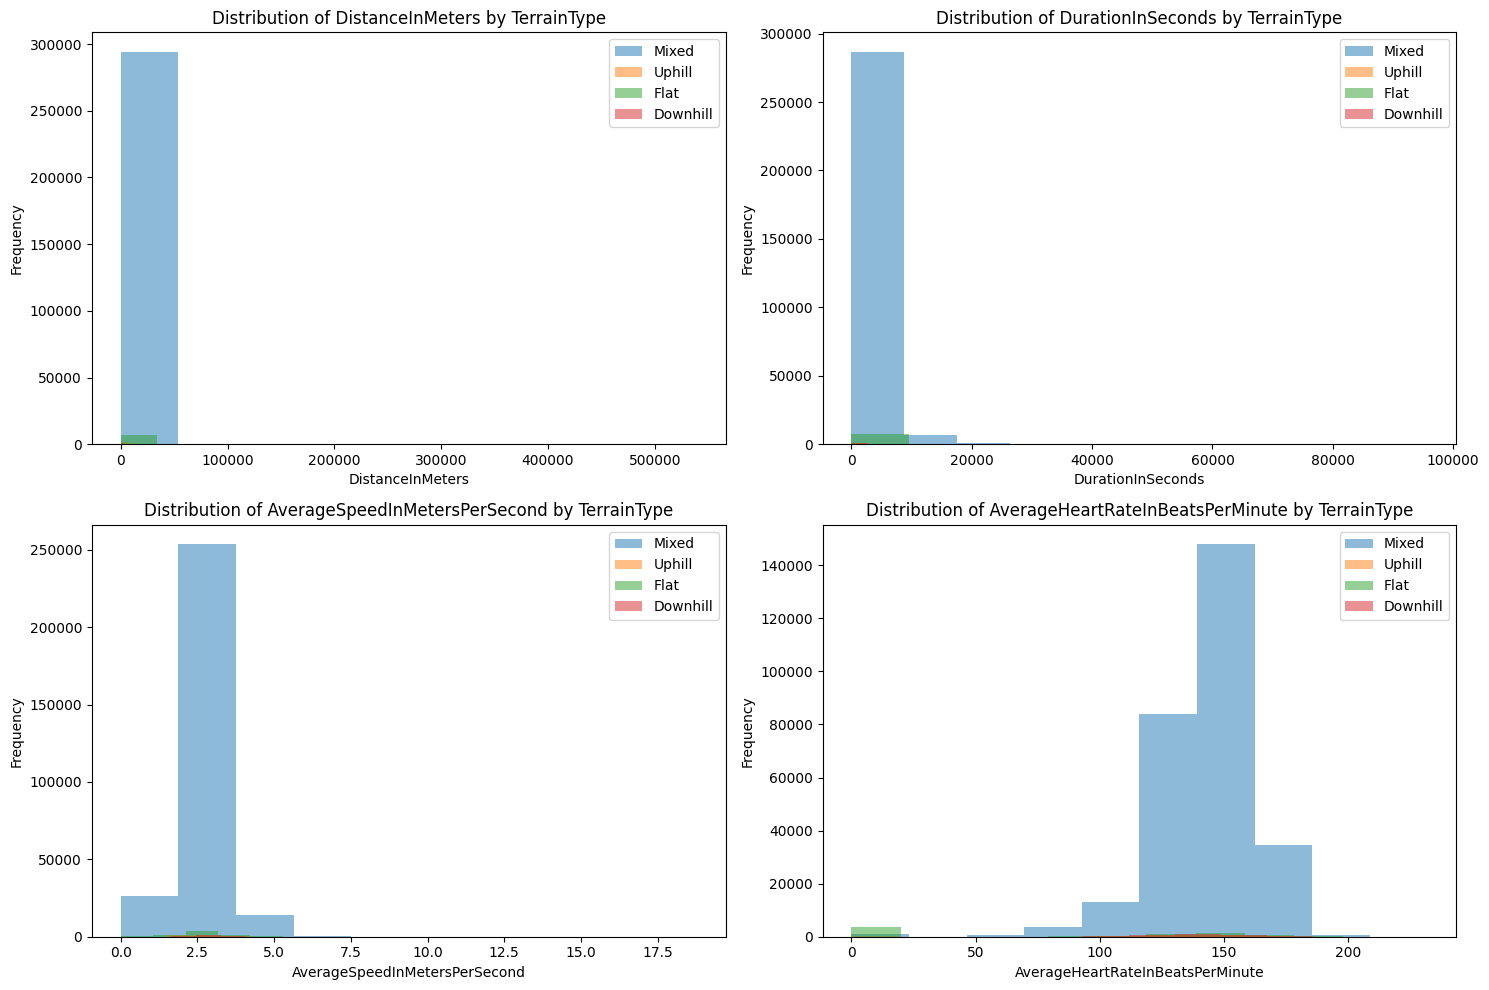

In [376]:
# Numerical variables to analyze
numerical_cols = ['DistanceInMeters', 'DurationInSeconds', 'AverageSpeedInMetersPerSecond', 'AverageHeartRateInBeatsPerMinute']

# 1. Descriptive statistics grouped by TerrainType
descriptive_stats = df.groupby('TerrainType')[numerical_cols].describe()
display(descriptive_stats)

# 2. Visualize distributions
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    for terrain_type in df['TerrainType'].unique():
        plt.hist(df[df['TerrainType'] == terrain_type][col].dropna(), alpha=0.5, label=terrain_type)
    plt.title(f'Distribution of {col} by TerrainType')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
plt.tight_layout()
plt.show()


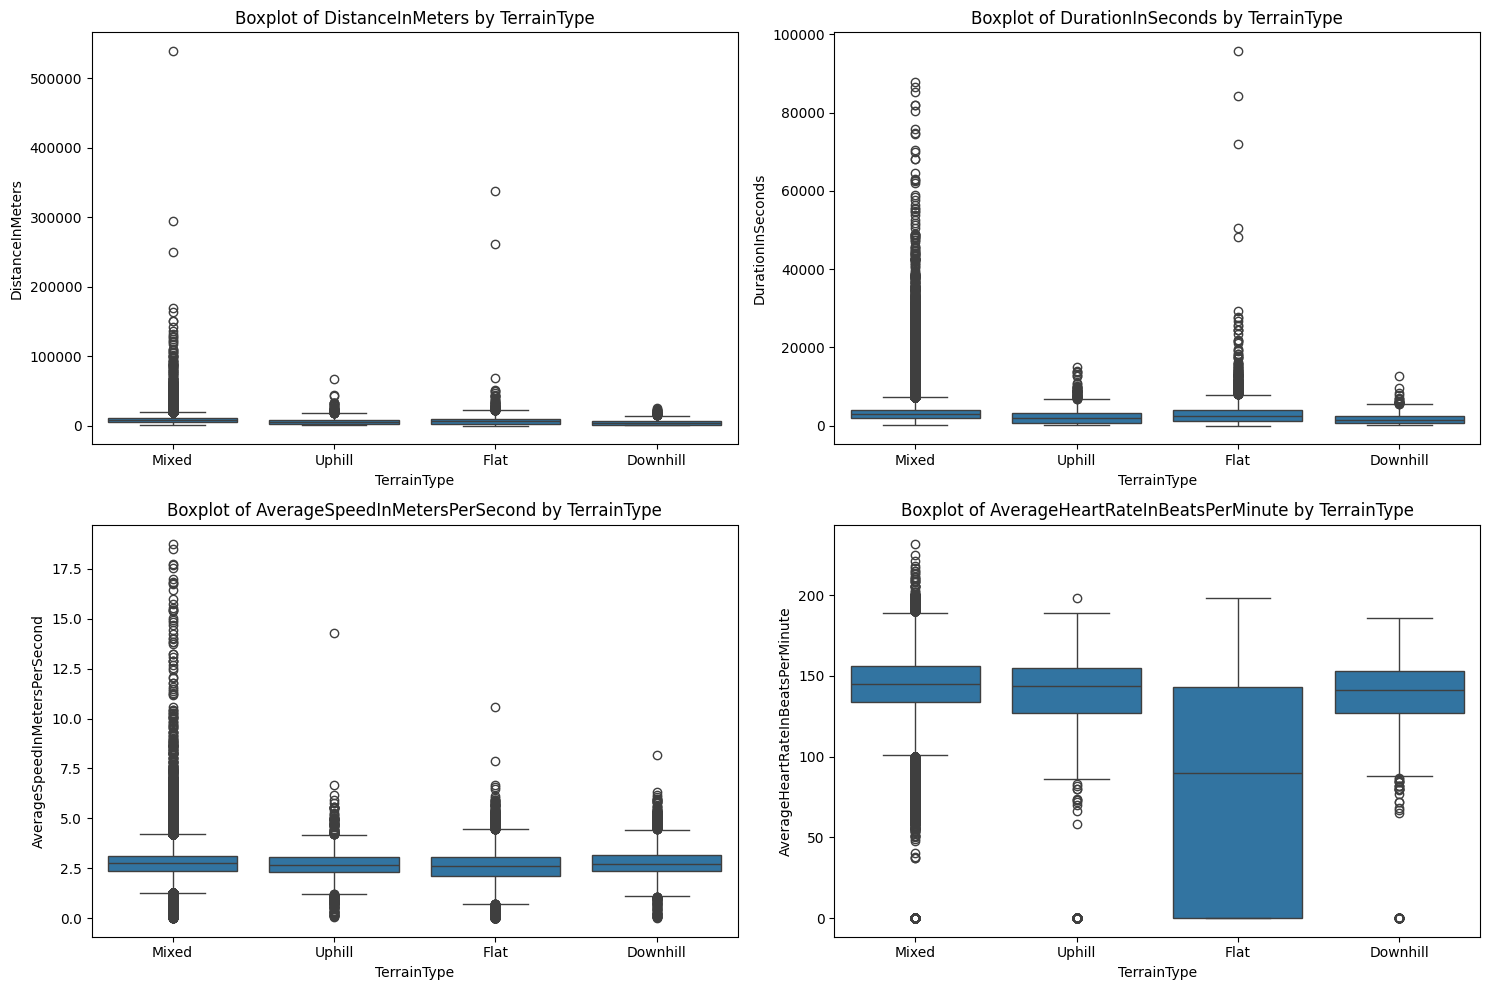

In [377]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='TerrainType', y=col, data=df)
    plt.title(f'Boxplot of {col} by TerrainType')
plt.tight_layout()
plt.show()


En los Boxplot se evidencia que con la clasificación de TerrainType en 4 categorías: Flat, Uphill, Downhill y Mixed, se observa que los terrenos Mixed y Flat presentan una mayor probabilidad de contener datos atípicos en cada una de las variables.

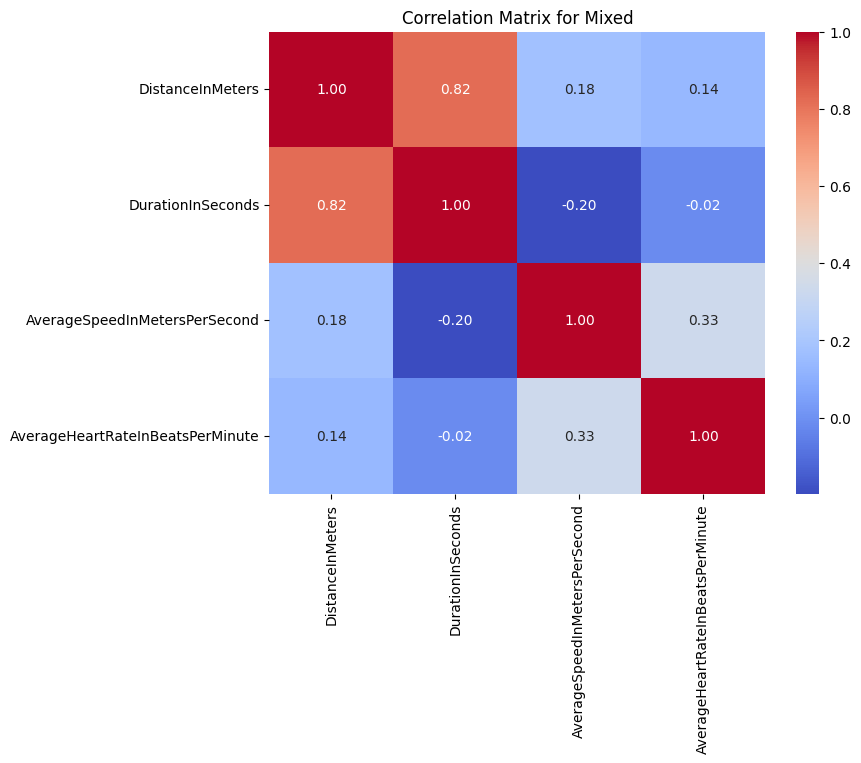

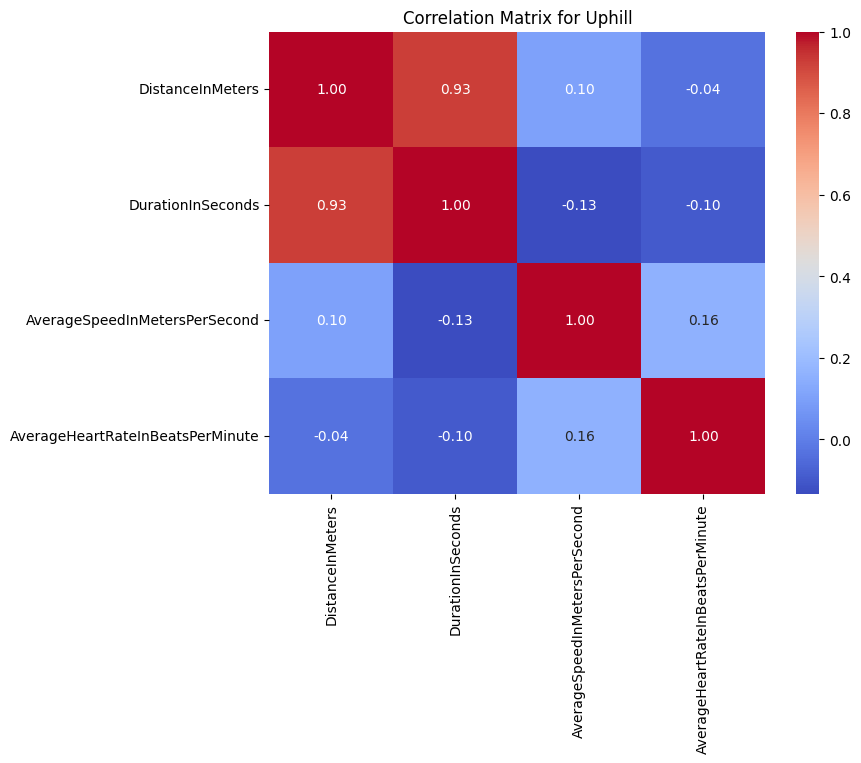

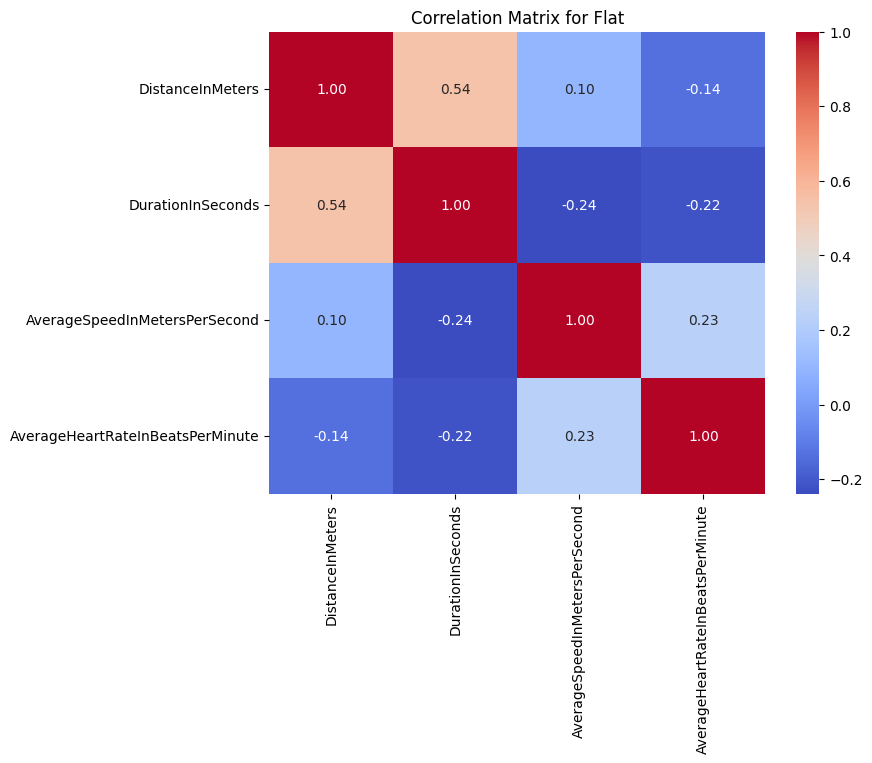

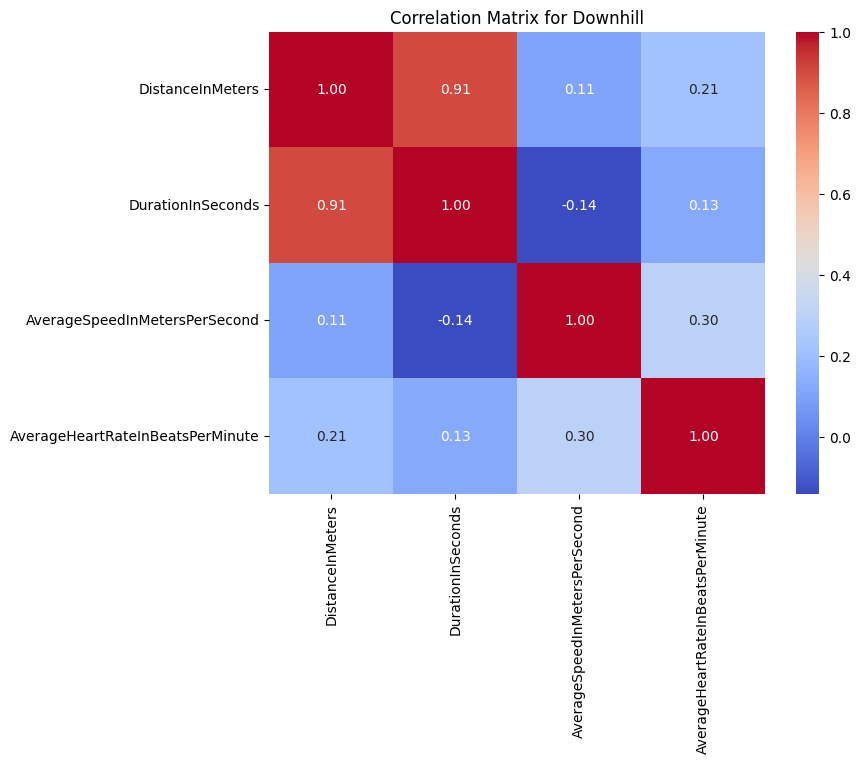

In [378]:
# 3. Correlation matrices and heatmaps
for terrain_type in df['TerrainType'].unique():
    terrain_data = df[df['TerrainType'] == terrain_type]
    correlation_matrix = terrain_data[numerical_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Matrix for {terrain_type}')
    plt.show()

# Revisión del df resultante después del análisis de variables inicial

In [379]:
df.shape

(306017, 13)

Los datos originales eran (351195, 16), lo que quiere decir que a nivel de registros se ha eliminado el 12.8% de los datos

In [380]:
df.describe()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week
count,306017.000000,306017.000000,304417.000000,306017.000000,306017.000000,296969.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000
mean,3195.481042,8347.254995,7990.415933,2.728146,9.390113,141.528671,2024.388201,7.143084,15.278919,13.497505,3.156795
std,2542.812261,6033.532835,6069.552229,0.713218,437.567220,25.142673,0.509078,4.691446,8.691421,5.635717,1.969467
min,1.000000,0.010000,0.000000,0.000000,0.183649,0.000000,2014.000000,1.000000,1.000000,0.000000,0.000000
25%,1800.000000,4701.150000,4068.000000,2.363000,5.369416,133.000000,2024.000000,2.000000,8.000000,10.000000,1.000000
50%,2814.000000,7397.750000,7230.000000,2.739000,6.091191,145.000000,2024.000000,10.000000,15.000000,12.000000,3.000000
75%,3950.000000,10512.250000,10524.000000,3.105000,7.065141,155.000000,2025.000000,11.000000,22.000000,17.000000,5.000000
max,95739.000000,539273.000000,192006.000000,18.775000,209166.666667,232.000000,2025.000000,12.000000,31.000000,23.000000,6.000000


In [381]:
df.isna().sum()

DurationInSeconds                      0
DistanceInMeters                       0
Steps                               1600
AverageSpeedInMetersPerSecond          0
AveragePaceInMinutesPerKilometer       0
AverageHeartRateInBeatsPerMinute    9048
SourceName                           982
Year                                   0
Month                                  0
Day                                    0
Hour                                   0
Day_of_week                            0
TerrainType                            0
dtype: int64

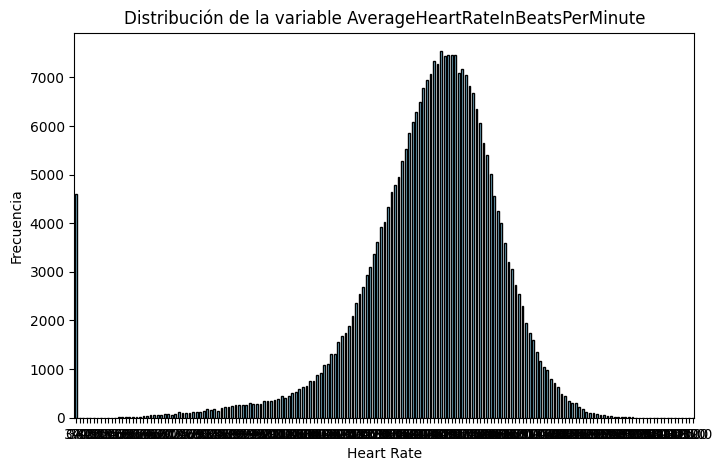

In [382]:
# Contenteo de datos solo con números enteros para la variable AverageHeartRateInBeatsPerMinute. Esto solo con fines analíticos, no se afectará el dataset original
acumuladoRate = df['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()

plt.figure(figsize=(8, 5))
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black')

# Personalizar etiquetas
plt.xlabel('Heart Rate')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable AverageHeartRateInBeatsPerMinute')
plt.xticks(rotation=0)

plt.show()

In [383]:
len(df[(df['AverageHeartRateInBeatsPerMinute']==0)])

4610

Para poder hacer imputaciones con KNN y que se considere el terreno, es necesario usar One-Hot Encoding para convertirlo en valores numéricos y que el proceso funcione adecuadamente

In [410]:
df_encoded = pd.get_dummies(df, columns=['TerrainType'])
df_encoded.describe()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week
count,306017.000000,306017.000000,304417.000000,306017.000000,306017.000000,296969.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000
mean,3195.481042,8347.254995,7990.415933,2.728146,9.390113,141.528671,2024.388201,7.143084,15.278919,13.497505,3.156795
std,2542.812261,6033.532835,6069.552229,0.713218,437.567220,25.142673,0.509078,4.691446,8.691421,5.635717,1.969467
min,1.000000,0.010000,0.000000,0.000000,0.183649,0.000000,2014.000000,1.000000,1.000000,0.000000,0.000000
25%,1800.000000,4701.150000,4068.000000,2.363000,5.369416,133.000000,2024.000000,2.000000,8.000000,10.000000,1.000000
50%,2814.000000,7397.750000,7230.000000,2.739000,6.091191,145.000000,2024.000000,10.000000,15.000000,12.000000,3.000000
75%,3950.000000,10512.250000,10524.000000,3.105000,7.065141,155.000000,2025.000000,11.000000,22.000000,17.000000,5.000000
max,95739.000000,539273.000000,192006.000000,18.775000,209166.666667,232.000000,2025.000000,12.000000,31.000000,23.000000,6.000000


In [385]:
# Hacer imputación de valores faltantes y nulos en la variable 'AverageHeartRateInBeatsPerMinute' usando KNN y considerando columnas específicas
"""
columnas_para_imputacion = [
    'DurationInSeconds', 
    'DistanceInMeters', 
    'AverageSpeedInMetersPerSecond', 
    'Day', 
    'TerrainType_Downhill', 
    'TerrainType_Flat', 
    'TerrainType_Mixed', 
    'TerrainType_Uphill',
    'AverageHeartRateInBeatsPerMinute'
]

df_encoded['AverageHeartRateInBeatsPerMinute'] = df_encoded['AverageHeartRateInBeatsPerMinute'].replace(0, np.nan)

imputer = KNNImputer(n_neighbors=3)  
df_encoded[['AverageHeartRateInBeatsPerMinute']] = imputer.fit_transform(df_encoded[columnas_para_imputacion])[:, -1].reshape(-1, 1)

df_encoded['AverageHeartRateInBeatsPerMinute'].describe()
"""

"\ncolumnas_para_imputacion = [\n    'DurationInSeconds', \n    'DistanceInMeters', \n    'AverageSpeedInMetersPerSecond', \n    'Day', \n    'TerrainType_Downhill', \n    'TerrainType_Flat', \n    'TerrainType_Mixed', \n    'TerrainType_Uphill',\n    'AverageHeartRateInBeatsPerMinute'\n]\n\ndf_encoded['AverageHeartRateInBeatsPerMinute'] = df_encoded['AverageHeartRateInBeatsPerMinute'].replace(0, np.nan)\n\nimputer = KNNImputer(n_neighbors=3)  \ndf_encoded[['AverageHeartRateInBeatsPerMinute']] = imputer.fit_transform(df_encoded[columnas_para_imputacion])[:, -1].reshape(-1, 1)\n\ndf_encoded['AverageHeartRateInBeatsPerMinute'].describe()\n"

In [411]:
columnas_para_imputacion = [
    'DurationInSeconds', 
    'DistanceInMeters', 
    'Steps',
    'AverageSpeedInMetersPerSecond', 
    'Day', 
    'TerrainType_Downhill', 
    'TerrainType_Flat', 
    'TerrainType_Mixed', 
    'TerrainType_Uphill',
    'AverageHeartRateInBeatsPerMinute'
]

df_encoded['AverageHeartRateInBeatsPerMinute'] = df_encoded['AverageHeartRateInBeatsPerMinute'].replace(0, np.nan)
df_encoded['Steps'] = df_encoded['Steps'].replace(0, np.nan)
imputer = KNNImputer(n_neighbors=3)  
df_encoded[columnas_para_imputacion] = imputer.fit_transform(df_encoded[columnas_para_imputacion])
df_encoded.describe()


,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill
count,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000,306017.000000
mean,3195.481042,8347.254995,8373.998910,2.728146,9.390113,143.667927,2024.388201,7.143084,15.278919,13.497505,3.156795,0.007964,0.023799,0.961394,0.006843
std,2542.812261,6033.532835,5939.980011,0.713218,437.567220,17.818547,0.509078,4.691446,8.691421,5.635717,1.969467,0.088883,0.152424,0.192654,0.082438
min,1.000000,0.010000,1.000000,0.000000,0.183649,37.000000,2014.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1800.000000,4701.150000,4626.000000,2.363000,5.369416,134.000000,2024.000000,2.000000,8.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,2814.000000,7397.750000,7500.000000,2.739000,6.091191,145.000000,2024.000000,10.000000,15.000000,12.000000,3.000000,0.000000,0.000000,1.000000,0.000000
75%,3950.000000,10512.250000,10710.000000,3.105000,7.065141,155.000000,2025.000000,11.000000,22.000000,17.000000,5.000000,0.000000,0.000000,1.000000,0.000000
max,95739.000000,539273.000000,192006.000000,18.775000,209166.666667,232.000000,2025.000000,12.000000,31.000000,23.000000,6.000000,1.000000,1.000000,1.000000,1.000000


In [387]:
df_encoded.isna().sum()

DurationInSeconds                     0
DistanceInMeters                      0
Steps                                 0
AverageSpeedInMetersPerSecond         0
AveragePaceInMinutesPerKilometer      0
AverageHeartRateInBeatsPerMinute      0
SourceName                          982
Year                                  0
Month                                 0
Day                                   0
Hour                                  0
Day_of_week                           0
TerrainType_Downhill                  0
TerrainType_Flat                      0
TerrainType_Mixed                     0
TerrainType_Uphill                    0
dtype: int64

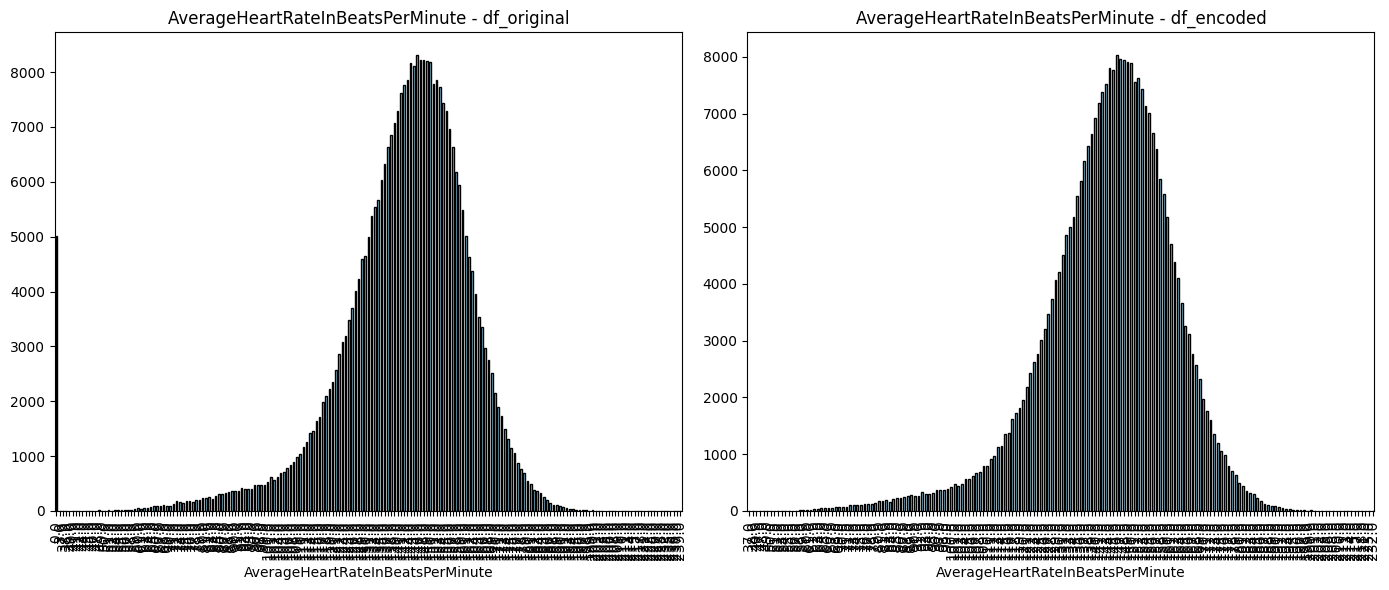

In [388]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
acumuladoRate = df_original['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[0])
axes[0].set_title('AverageHeartRateInBeatsPerMinute - df_original')

acumuladoRate = df_encoded['AverageHeartRateInBeatsPerMinute'].round().value_counts().sort_index()
acumuladoRate.plot(kind='bar', color='skyblue', edgecolor='black', ax=axes[1])
axes[1].set_title('AverageHeartRateInBeatsPerMinute - df_encoded')
plt.tight_layout() 
plt.show()

Con los resultados anteriores podemos ver que el proceso de imputación no afectó la disrtibución de las variables

# Escalar variables

In [412]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_features = ['DurationInSeconds', 'DistanceInMeters', 'Steps', 'AverageSpeedInMetersPerSecond', 'AveragePaceInMinutesPerKilometer', 'AverageHeartRateInBeatsPerMinute']
df_encoded[numerical_features] = scaler.fit_transform(df_encoded[numerical_features])
df_encoded.head()

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,SourceName,Year,Month,Day,Hour,Day_of_week,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill
0,-0.349016,-0.380732,-0.264648,-0.148828,-0.006933,0.074758,Forerunner 35,2024,9,30.0,20,0,0.0,0.0,1.0,0.0
2,-1.130829,-1.255780,-1.265663,-0.450279,-0.005635,-1.665005,Forerunner 255S Music,2024,9,30.0,23,0,0.0,0.0,1.0,0.0
3,-0.511435,-0.553845,-0.525255,-0.120786,-0.007043,0.130879,Forerunner 45,2024,9,30.0,23,0,0.0,0.0,1.0,0.0
4,0.468191,0.336282,0.518185,-0.509167,-0.005354,-0.037485,Forerunner 55,2024,9,30.0,21,0,0.0,0.0,1.0,0.0
5,-0.055640,-0.055376,0.008418,-0.146023,-0.006944,0.467608,Forerunner 55,2024,9,30.0,23,0,0.0,0.0,1.0,0.0


# DBSCAN 

Density-Based Spatial Clustering of Applications with Noise es un algoritmo de clustering que agrupa puntos en función de su densidad y será usado para el proceso de identificación de datos atípicos

In [413]:
# Eliminar SourceName para hacer el análisis DBSCAN
df_encoded = df_encoded.drop('SourceName', axis=1)

In [414]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)

dbscan.fit(df_encoded)

cluster_labels = dbscan.labels_

# Add cluster labels to the DataFrame using .loc
df_encoded.loc[:, 'cluster_labels'] = cluster_labels

display(df_encoded.head())

,DurationInSeconds,DistanceInMeters,Steps,AverageSpeedInMetersPerSecond,AveragePaceInMinutesPerKilometer,AverageHeartRateInBeatsPerMinute,Year,Month,Day,Hour,Day_of_week,TerrainType_Downhill,TerrainType_Flat,TerrainType_Mixed,TerrainType_Uphill,cluster_labels
0,-0.349016,-0.380732,-0.264648,-0.148828,-0.006933,0.074758,2024,9,30.0,20,0,0.0,0.0,1.0,0.0,-1
2,-1.130829,-1.255780,-1.265663,-0.450279,-0.005635,-1.665005,2024,9,30.0,23,0,0.0,0.0,1.0,0.0,-1
3,-0.511435,-0.553845,-0.525255,-0.120786,-0.007043,0.130879,2024,9,30.0,23,0,0.0,0.0,1.0,0.0,0
4,0.468191,0.336282,0.518185,-0.509167,-0.005354,-0.037485,2024,9,30.0,21,0,0.0,0.0,1.0,0.0,-1
5,-0.055640,-0.055376,0.008418,-0.146023,-0.006944,0.467608,2024,9,30.0,23,0,0.0,0.0,1.0,0.0,0


PCA en 2 dimensiones

In [415]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_encoded.drop(columns=['cluster_labels']))

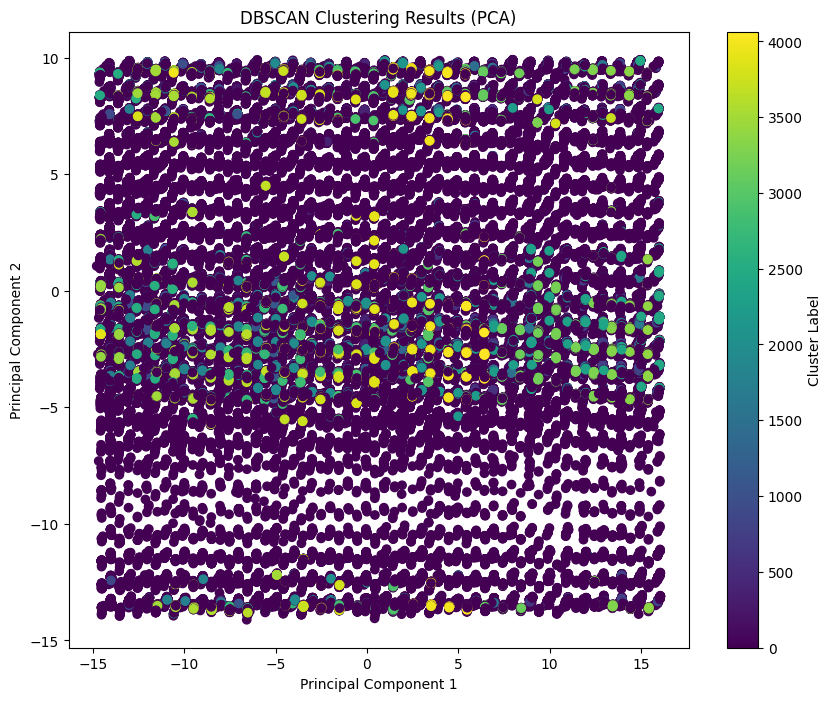

In [ ]:
# Create a scatter plot of the data points, colored by cluster
plt.figure(figsize=(10, 8))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=df_encoded['cluster_labels'], cmap='viridis')
plt.title('DBSCAN Clustering Results (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

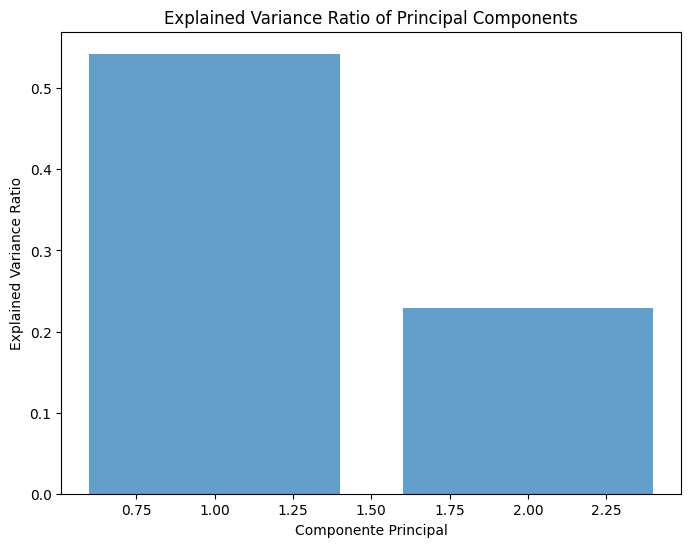

In [393]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, 3), pca.explained_variance_ratio_, alpha=0.7)  
plt.xlabel('Componente Principal')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

In [416]:
from mpl_toolkits.mplot3d import Axes3D  

# Aplicar PCA con 3 componentes
pca = PCA(n_components=3)
df_pca = pca.fit_transform(df_encoded.drop(columns=['cluster_labels']))

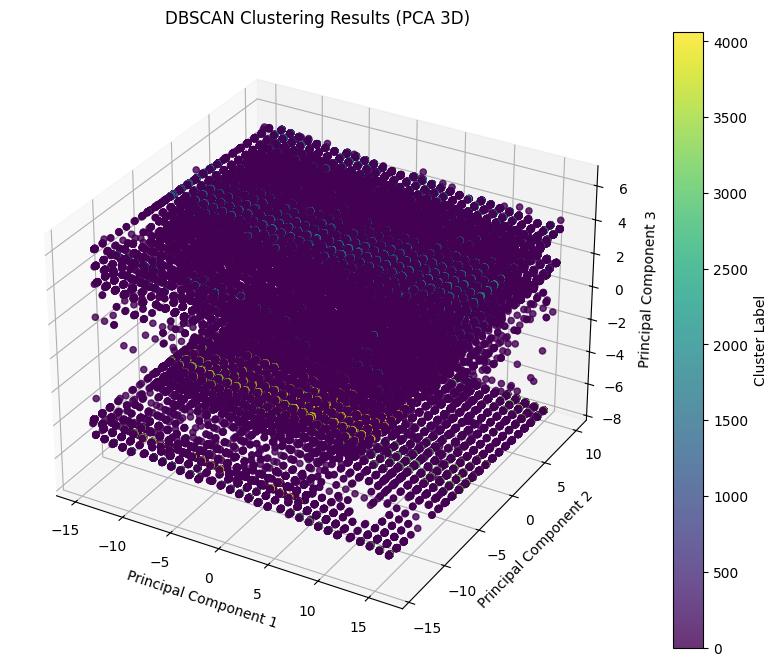

In [ ]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficar los puntos con sus clusters
scatter = ax.scatter(df_pca[:, 0], df_pca[:, 1], df_pca[:, 2], 
                     c=df_encoded['cluster_labels'], cmap='viridis', alpha=0.8)

ax.set_title('DBSCAN Clustering Results (PCA 3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.colorbar(scatter, label="Cluster Label")
plt.show()

- Si los puntos forman grupos definidos, significa que DBSCAN ha encontrado patrones claros en los datos. En este caso no es muy evidente

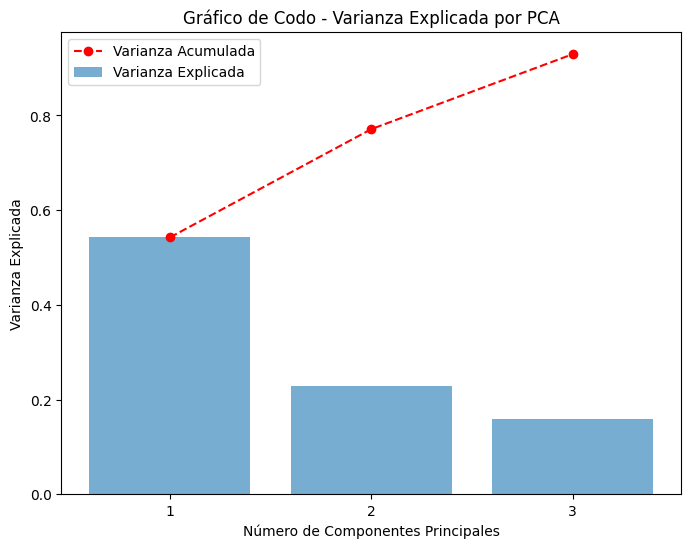

In [395]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)  # Suma acumulada

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza Explicada')
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='red', label='Varianza Acumulada')

plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Gráfico de Codo - Varianza Explicada por PCA')
plt.legend()
plt.xticks(range(1, len(explained_variance) + 1))
plt.show()

- Las barras azules representan la varianza explicada por cada componente principal.
- La línea roja punteada muestra la varianza acumulada a medida que se agregan más componentes.
- Si la varianza acumulada alcanza un valor alto por encima del 80% con pocas componentes, significa que la reducción de dimensionalidad es efectiva y se conserva mucha información de los datos originales. En este caso, parece que con 2 0 3 componentes se puede explicar una gran parte de la varianza total, lo que justificaría el uso de PCA para visualizar y reducir dimensiones.

# Isolation Forest Model

In [417]:
y = df_encoded['AverageSpeedInMetersPerSecond']
y_binned = pd.qcut(y, q=5, labels=False)
y_binned.value_counts()

AverageSpeedInMetersPerSecond
1    61265
0    61239
2    61185
4    61173
3    61155
Name: count, dtype: int64

In [418]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

df_encoded.drop('cluster_labels', axis=1)

X = df_encoded.drop('AverageSpeedInMetersPerSecond', axis=1)
y = df_encoded['AverageSpeedInMetersPerSecond']

# y tiene valores únicos, lo que hace que el stratify falle, por eso dividir la velocidad en 5 categorías es necesario 
y_binned = pd.qcut(y, q=5, labels=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y_binned)

IsolationForestModel = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

IsolationForestModel.fit(X_train)

y_train_pred = IsolationForestModel.predict(X_train)
y_test_pred = IsolationForestModel.predict(X_test)

In [419]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# Adjust labels to 0 and 1
y_test_adjusted = np.where(y_test_pred == -1, 0, 1)
y_test = np.where(y_test == -1, 0, 1)

accuracy = accuracy_score(y_test, y_test_adjusted)
precision = precision_score(y_test, y_test_adjusted)
recall = recall_score(y_test, y_test_adjusted)
f1 = f1_score(y_test, y_test_adjusted)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

cm = confusion_matrix(y_test, y_test_adjusted)
print("\nConfusion Matrix:")
print(cm)

Accuracy: 0.9046304163126593
Precision: 1.0
Recall: 0.9046304163126593
F1-score: 0.949927511988402

Confusion Matrix:
[[    0     0]
 [ 5837 55367]]


Analisis de las variables en función de las reglas de negocio

In [399]:
print("Registros de menos de 5 minutos:",len(df[(df['DurationInSeconds']<=300)]))
durationInMinutes = df['DurationInSeconds']/60
elevationPerMinute = df['TotalElevationGainInMeters']/durationInMinutes
print('Registros con elevación ganada mayor a 8 metros por minuto:',(elevationPerMinute > 8).sum() )
print('Registros con ritmo menor a 3.5 minutos por kilometro:', ((durationInMinutes/(df['DistanceInMeters']/1000)) < 3.5).sum())
print('Registros con ritmo menor a 3.5 minutos por kilometro:',  (df['AveragePaceInMinutesPerKilometer'] < 3.5).sum())
print('Registros con distancia en 0:', (df['DistanceInMeters']==0).sum())

Registros de menos de 5 minutos: 6929


KeyError: 'TotalElevationGainInMeters'

In [ ]:
# Tratamiento de nulos

# Imputar valores de AverageSpeedInMeterPerSecond y AveragePaceInMinutesPerKilometer
# Se realiza el calculo manual

# Solo calcula el ritmo donde AveragePaceInMinutesPerKilometer es nulo
mask = df['AveragePaceInMinutesPerKilometer'].isna()

df.loc[mask, 'AveragePaceInMinutesPerKilometer'] = (df['DurationInSeconds'] / 60) / (df['DistanceInMeters'] / 1000)

# Solo calcula el ritmo donde AverageSpeedInMeterPerSecond es nulo
mask = df['AverageSpeedInMeterPerSecond'].isna()

df.loc[mask, 'AverageSpeedInMeterPerSecond'] = df['DistanceInMeters'] / df['DurationInSeconds']

# TODO: Que hacer con los nulos de steps, averageHeartRateInBeatsPerMinute y sourceName
# Para averageHeartRateInBeatsPerMinute imputar con valores similares (KNN)

# TODO: Preguntar si se es correcto hacer imputación de averageHeartRateInBeatsPerMinute
features = ["DistanceInMeters", "DurationInSeconds", "TotalElevationGainInMeters","TotalElevationLossInMeters", "AverageSpeedInMetersPerSecond", "AveragePaceInMinutesPerKilometer"]
df_knn = df[features]
imputer = KNNImputer(n_neighbors=5)
df_knn["averageHeartRateInBeatsPerMinute"] = imputer.fit_transform(df_knn)[
    :, df_knn.columns.get_loc("averageHeartRateInBeatsPerMinute")
]
df['averageHeartRateInBeatsPerMinute'] = df_knn['averageHeartRateInBeatsPerMinute']


###Analisis de outliers


* DistanceInMeters: Distancia recorrida durante la actividad, expresada en metros.
* AverageHeartRateInBeatsPerMinute: Frecuencia cardíaca promedio durante la actividad, medida en latidos por minuto (BPM).
* AveragePaceInMinutesPerKilometer: Ritmo promedio de la actividad, expresado en minutos por kilómetro.


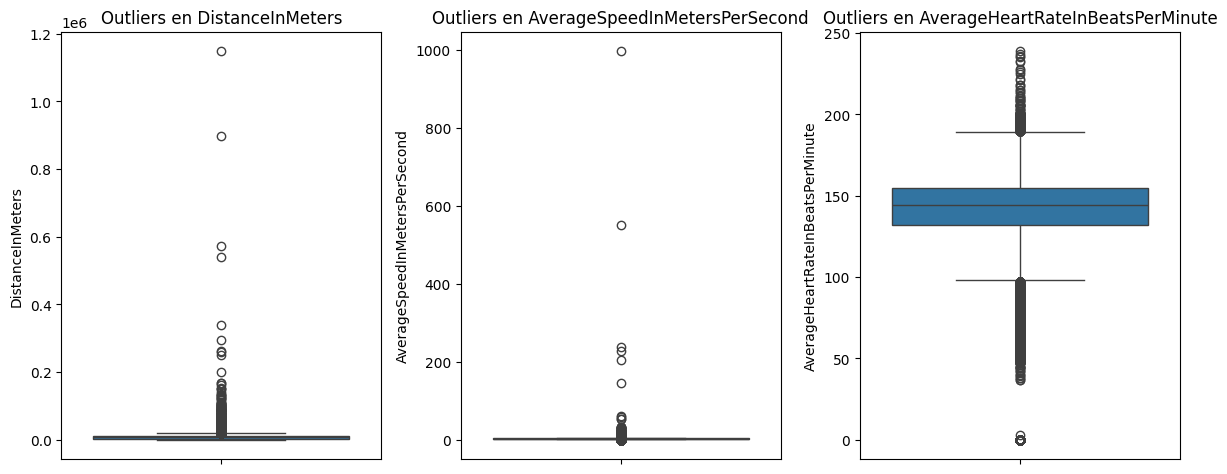

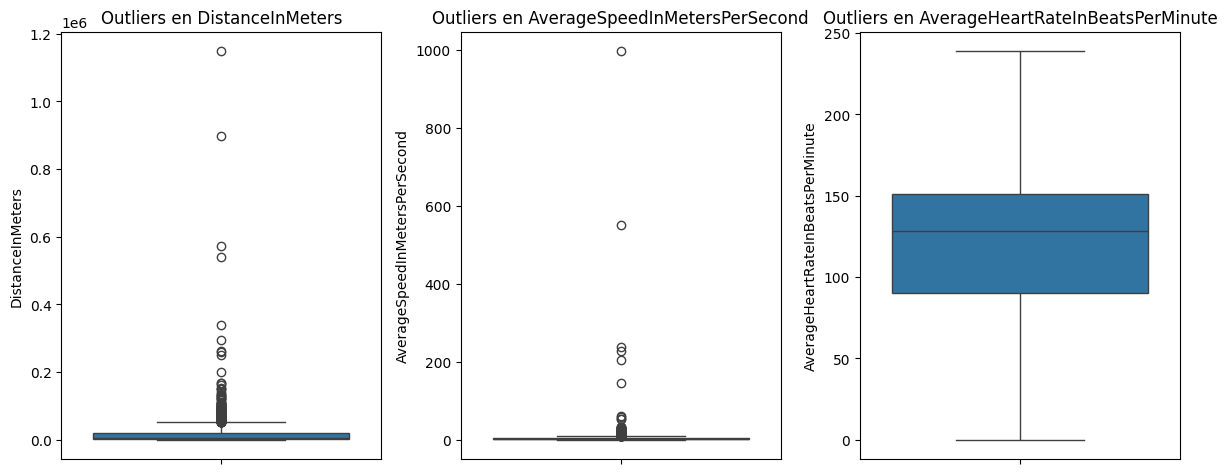

In [ ]:
outlier_cols = ["DistanceInMeters", "AverageSpeedInMetersPerSecond", "AverageHeartRateInBeatsPerMinute"]

plt.figure(figsize=(12, 5))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Outliers en {col}")
plt.tight_layout()
plt.show()

# Detección de outliers con el método IQR
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers

# Crear boxplots solo con los outliers
df_outliers = pd.DataFrame()
for col in outlier_cols:
    df_outliers = pd.concat([df_outliers, detect_outliers_iqr(df, col)])

df_outliers = df_outliers.drop_duplicates()

plt.figure(figsize=(12, 5))
for i, col in enumerate(outlier_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(y=df_outliers[col])
    plt.title(f"Outliers en {col}")
plt.tight_layout()
plt.show()

**Conclusiones Outliers**

TODO

#Limpieza de datos


Ahora empezaremos a crear reglas para la limpieza de datos, para esto debemos dividir los datos en set de entrenamiento y set de validación y set de prueba.

##Division de datasets


##Imputación


#Feature Engineering


##Dummificar variables
